In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [2]:
# The line of reasoning is 

# Quantiles have some volatility that depends on their n. 

#Factors that play a role are:

# gaussian vs actual growth rates.
# 2 step growth rates (ie. include autocorrelation)


## Empirical growth rates

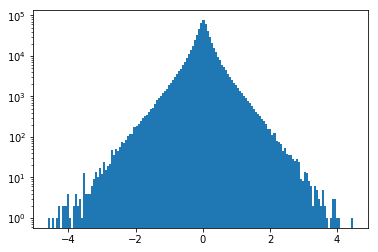

0.4273679067783249

In [3]:
data_path = './../../data/processed/'

df = pd.read_csv(data_path + 'ID_Y.csv')
df = df.loc[df.IMPORT == 0]

cuadro = df.set_index(['ID', 'YEAR'])[['VART']].unstack()

# Firms present in at least some time periods
cuadro = cuadro.loc[cuadro.count(1) > 12]
cuadro_rolled = cuadro

annual_logdiff = np.log10(cuadro_rolled).diff(1, axis = 1).replace(np.inf, np.nan).replace(-np.inf, np.nan).dropna(how = 'all')
annual_log = np.log10(cuadro_rolled.reindex(annual_logdiff.index))

annual_log.columns = annual_log.columns.set_levels(annual_log.columns.levels[0].str.replace('VART', 'annual_log'), level=0)
annual_logdiff.columns = annual_logdiff.columns.set_levels(annual_logdiff.columns.levels[0].str.replace('VART', 'annual_logdiff'), level=0)

df_concat = pd.concat([annual_log, annual_logdiff], axis = 1)

df_level_g = df_concat.stack()

g_rates = df_level_g.dropna()['annual_logdiff']
plt.hist(g_rates.values, 150)
plt.yscale('log')
plt.show()
g_rates.std()

### 2 step growth rates

In [4]:
annual_logdiff = annual_logdiff.dropna(how = 'all').dropna(axis = 1, how = 'all')#.head(50000)

vals = np.reshape(annual_logdiff.values, (int(np.prod(annual_logdiff.shape)/2), 2))
growth_rates_2s = pd.DataFrame(vals, columns = [0, 1], index = int(annual_logdiff.shape[1]/2)*list(annual_logdiff.index)).dropna()

## split into quantiles

In [5]:
df = pd.read_csv('./../../data/processed/ID_Y.csv')
df = df.loc[df.IMPORT == 0]

# plt.hist(df.groupby(['ID','IMPORT']).count()['YEAR'], range(15))


In [6]:
cuadro = df.set_index(['ID', 'YEAR'])['VART'].unstack().dropna()

Q = 14
cuadro['quantile'] = pd.cut(cuadro.mean(1).sort_values().cumsum(), Q)
I = Q

# cuadroq_ = cuadro.loc[cuadro['quantile'] != cuadro['quantile'].sort_values().values[0]]
# cuadroq1 = cuadro.loc[cuadro['quantile'] == cuadro['quantile'].sort_values().values[0]]
# cuadroq1['quantile'] = pd.cut(cuadroq1.mean(1).sort_values().cumsum()**(1/2), Q)
# cuadro = pd.concat([cuadroq_, cuadroq1])
# I = Q + Q -1


In [7]:

# cuadro['quantile'].value_counts() #N.

# Sizes
sizes = cuadro.groupby('quantile').mean().mean(1)

sizes_median = cuadro.groupby('quantile').median().median(1)

# N
N = cuadro['quantile'].value_counts()

# firm level Std
std_q = []
for q in cuadro['quantile'].sort_values().unique():
    q_chunk = cuadro.loc[cuadro['quantile'] == q].drop('quantile', axis = 1)
    log_chunk = np.log10(q_chunk).replace(-np.inf, np.nan).replace(np.inf, np.nan)
    std_q += [log_chunk.diff(axis = 1).dropna(axis = 1, how = 'all').stack().std()]

std = pd.Series(std_q, index = cuadro['quantile'].unique(), name='std').sort_index()

quantile_total = pd.DataFrame(cuadro.groupby('quantile').sum().values,
                              index = range(I), columns=range(1997, 2014))

quantile_diff = np.log10(quantile_total).T.diff()
quantile_diff_dem = (quantile_diff.T - quantile_diff.median(1)).T

In [8]:
# y = np.log10(quantile_total).T.diff().dropna().values.flatten()
# # it is about 1/2 of using pct change
# x = quantile_total.T.pct_change().dropna().values.flatten()

# plt.plot(x, y, marker = '.', lw = 0)

In [9]:
# cuadro.groupby('quantile').std()#.mean(1)
# df_concat

In [10]:
# quantile_diff_dem.plot(marker = '.')

In [11]:
long = quantile_diff_dem.T.stack()
# long = long.head()
long.index = long.index.get_level_values(0)#.plot()

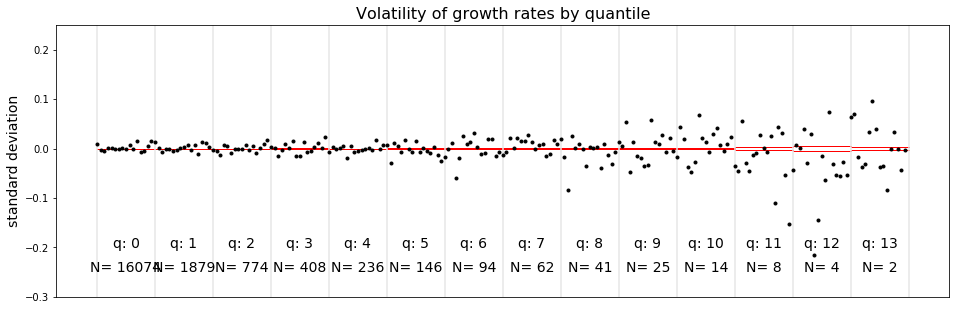

In [12]:
fig, ax = plt.subplots(1, figsize = (16, 5))

ax.plot(range(len(long)), long, lw = 0, marker = '.', c =  'k')

stds = long.groupby(level = 0).var()
stds = stds.append(pd.Series({len(stds): stds.loc[len(stds) - 1]}))

ax.step((2013 - 1997)*stds.index, stds, where='post', label='post', color = 'r', lw = 1, zorder = -20)
ax.step((2013 - 1997)*stds.index, -stds, where='post', label='post', color = 'r', lw = 1, zorder = -20)

for l in range(I + 1):
    ax.axvline((2013 - 1997)*l, c = '.9', linestyle = '-', zorder = -10) 

ax.set_ylim(-.3, .25)

for q in range(I):
#     print()
    ax.annotate('q: '+str(q), 
            xy=(16*q + 8, -.2), ha="center", fontsize=14)
    ax.annotate('N= '+str(N.iloc[q]), 
            xy=(16*q + 8, -.25), ha="center", fontsize=14)

ax.set_xticks([])
ax.set_ylabel('standard deviation', fontsize = 14)
ax.set_title('Volatility of growth rates by quantile', fontsize = 16)
# plt.savefig('./../../../thesis_writing/figures/volatilities_quantile.png', dpi = 300)
plt.show()

## Simulate volatility
### Empirical, size dependent

In [13]:
# g_rates_val = g_rates.values

result_list = []
g_rates_result_list = []

for bin_, n in enumerate(N.values):
    bin_s = np.log10(sizes_median.iloc[bin_])
    g_rates = df_level_g.loc[abs(df_level_g.annual_log - bin_s) < .45].dropna()
    g_rates = g_rates['annual_logdiff'].clip(-.8, .8)
    g_rates_result_list += [pd.Series(g_rates).describe()]

    g_rates_val = g_rates.values
#     print(n)
    mu0 = bin_s
    x0 = mu0*np.ones(n)

    t_var = []
    for m in range(300):
        t = []
        for yrs in range((2013 - 1997)):
        #     x1 = np.random.normal(0, 0.2, n)
            x1 = np.random.choice(g_rates_val, n)
    #         t += [np.power(10, x0 + x1).sum()/(n*10**mu0)]
            t += [np.log10(np.power(10, x0 + x1).sum()) - np.log10(n) - mu0]
        t_var += [np.array(t)[1:].var()]
    
    s1 = np.array(t_var)
    result_list += [pd.Series(s1).describe()]

result = pd.DataFrame(pd.concat(result_list, axis = 1))
result.columns = N.values
result = result.T

## Empirical 2 step, size dependent

In [14]:
# g_rates_val = g_rates.values

result_list = []
g_rates_result_list = []

for bin_, n in enumerate(N.values):
    bin_s = np.log10(sizes_median.iloc[bin_])

    g_rates = df_level_g.loc[abs(df_level_g.annual_log - bin_s) < .45].dropna()
    
    g_rates = g_rates.reset_index()
    g_rates['YEAR_diff'] = g_rates['YEAR'].diff()
    g_rates = g_rates.loc[g_rates['YEAR_diff'] == 1].set_index(['ID', 'YEAR'])
    annual_logdiff = g_rates['annual_logdiff'].unstack().T.reindex(range(1998, 2014)).T
#     annual_logdiff = g_rates['annual_logdiff'].clip(-1, 1).unstack().T.reindex(range(1998, 2014)).T

    vals = np.reshape(annual_logdiff.values, (int(np.prod(annual_logdiff.shape)/2), 2))
    growth_rates_2s = pd.DataFrame(vals, columns = [0, 1], index = int(annual_logdiff.shape[1]/2)*list(annual_logdiff.index)).dropna()
    
    g_rates_val = growth_rates_2s.values
#     print(n)
    mu0 = bin_s
    x0 = mu0*np.ones(n)

    t_var = []
    for m in range(300):
        t = []
        for yrs in np.arange(1997, 2013, 2):
            x1 = g_rates_val[np.random.choice(range(len(g_rates_val)), n)]
            t += [np.log10(np.power(10, x0 + x1[:, 0] + x1[:, 1]).sum()) - np.log10(n) - mu0]
        t_var += [np.array(t)[1:].var()]
    
    s1 = np.array(t_var)
    result_list += [pd.Series(s1).describe()]

result1 = pd.DataFrame(pd.concat(result_list, axis = 1))
result1.columns = N.values
result1 = result1.T

### Gaussian

In [15]:
# g_rates_val = g_rates.values

result_list = []
g_rates_result_list = []

for bin_, n in enumerate(N.values):
    bin_s = np.log10(sizes_median.iloc[bin_])
#     bin_std = std.iloc[bin_]
    bin_std = std.median() # same std for all gaussian approxs

    mu0 = bin_s
    x0 = mu0*np.ones(n)

    t_var = []
    for m in range(300):
        t = []
        for yrs in range((2013 - 1997)):
            x1 = np.random.normal(0, bin_std, n)
#             x1 = np.random.choice(g_rates_val, n)
    #         t += [np.power(10, x0 + x1).sum()/(n*10**mu0)]
            t += [np.log10(np.power(10, x0 + x1).sum()) - np.log10(n) - mu0]
        t_var += [np.array(t)[1:].var()]
    
    s1 = np.array(t_var)
    result_list += [pd.Series(s1).describe()]
result2 = pd.DataFrame(pd.concat(result_list, axis = 1))
result2.columns = N.values
result2 = result2.T

### Empirical, size INdependent

In [16]:
# g_rates_val = g_rates.values

result_list = []
g_rates_result_list = []

for bin_, n in enumerate(N.values):
    bin_s = np.log10(sizes_median.iloc[bin_])
    g_rates = df_level_g.dropna()['annual_logdiff'].clip(-1, 1)
    g_rates_result_list += [pd.Series(g_rates).describe()]

    g_rates_val = g_rates.values
#     print(n)
    mu0 = bin_s
    x0 = mu0*np.ones(n)

    t_var = []
    for m in range(300):
        t = []
        for yrs in range((2013 - 1997)):
        #     x1 = np.random.normal(0, 0.2, n)
            x1 = np.random.choice(g_rates_val, n)
    #         t += [np.power(10, x0 + x1).sum()/(n*10**mu0)]
            t += [np.log10(np.power(10, x0 + x1).sum()) - np.log10(n) - mu0]
        t_var += [np.array(t)[1:].var()]
    
    s1 = np.array(t_var)
    result_list += [pd.Series(s1).describe()]

result3 = pd.DataFrame(pd.concat(result_list, axis = 1))
result3.columns = N.values
result3 = result3.T

In [17]:

# result.head()

# fig, ax = plt.subplots(1, figsize = (7, 6))
# x = N.values
# ax.plot(x, result['75%'], c = '.7')
# ax.plot(x, result['50%'], c = '.7', marker = '.')
# ax.plot(x, result['25%'], c = '.7')

# plt.xscale('log')
# # plt.ylim(0, .2)
# plt.show()

In [18]:
def distrib(sigmas):
    result = np.log10(np.array([np.power(10, np.random.normal(0, s, 40000)) for s in sigmas]).sum(0)/len(sigmas))
    return result

### ns = np.round((.3/y)**2)

## Simulation, effect of n only

In [19]:
cuadroq1 = cuadro.drop('quantile', axis = 1).loc[cuadro['quantile'] == cuadro['quantile'].sort_values().values[0]]
# cuadroq1['quantile'] = pd.cut(cuadroq1.mean(1).sort_values().cumsum()**(1/2), Q)

std_sample = []; n_sample = [];
for m in range(50):
    for l in np.arange(2, 4.4, .2):
        n = int(np.round(np.power(10, l)))
        q_chunk_sum = cuadroq1.sample(n, replace = True).sum()
        sample_diff = np.log10(q_chunk_sum).replace(-np.inf, np.nan).replace(np.inf, np.nan).diff()#
        sample_diff_dem = (sample_diff - quantile_diff.median(1)) # I subtract the median of the years...
        std_sample += [sample_diff_dem.var()]
        n_sample += [n]
        
x_ = np.array(n_sample)
y_ = np.array(std_sample)

sample_size_test = pd.DataFrame([x_, y_], index = ['N', 'var']).T.groupby('N').describe()['var']

In [20]:
# fig, ax = plt.subplots(1, figsize = (7, 6))
# x = N.values
# y = stds[1:].values
# ax.plot(x, y, marker = 'o')
# ax.plot(sample_size_test.index, sample_size_test['50%'], marker = '.', lw = 0, color = 'b')
# ax.fill_between(sample_size_test.index, sample_size_test['75%'], sample_size_test['25%'], color = 'b', alpha = .15, label = 'aggregate')
# # 
# ax.set_xscale('log')
# ax.set_yscale('log')

FileNotFoundError: [Errno 2] No such file or directory: './../../../thesis_writing/figures/quantiles_std_bands.png'

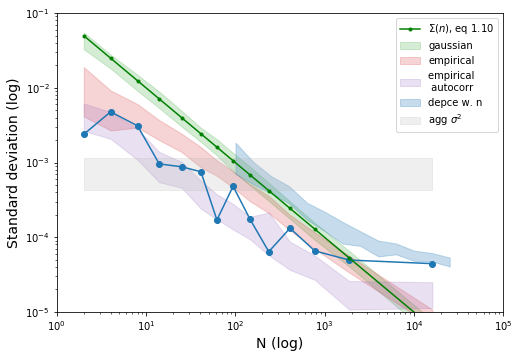

In [21]:
# fit bad data points
result1['75%'][774] = .5*(0.000027 + 0.000087)

fig, ax = plt.subplots(1, figsize = (8, 5.5))
x = N.values
y = stds[:-1].values
# ax.plot(x = N.values, y = stds[:-1].values, marker = 'o')
ax.plot(x, y, marker = 'o')

# # Gaussian expectation with the sigma of each bin
sigma = std
sigma = std.median()
sigma_correg = np.sqrt((np.exp(sigma**2))*(np.exp(sigma**2) - 1))
ax.plot(x, sigma_correg**2/x, marker = '.', c = 'g', label = r'$\Sigma(n)$, eq 1.10') # we can confirm it's a good approx
# ax.plot(x, std/np.sqrt(x), marker = '.', c= 'g')

# this is from using GAUSSIAN growth rates around each size to simulate the std
ax.fill_between(x, result2['25%'], result2['75%'], color = '#2ca02c', alpha = .2, label = 'gaussian')

# this is from using EMPIRICAL growth rates around each size to simulate the std
ax.fill_between(x, result['25%'], result['75%'], color = '#d62728', alpha = .2, label = 'empirical')

# this is from using EMPIRICAL 2 STEP growth rates around each size to simulate the std
ax.fill_between(x, result1['25%'], result1['75%'], color = '#9467bd', alpha = .2, label = 'empirical \n autocorr')

# # this is from using EMPIRICAL growth rates around each size to simulate the std
# ax.fill_between(x, result3['25%'], result3['75%'], color = '#9467bd', alpha = .2, label = 'empirical \n constant g')
# What happens here is in the end it's like using the massive smaller quantile. as it weighs much more.

# this is from changing sample size, with the same composition of the quantile of many small firms
ax.fill_between(sample_size_test.index, sample_size_test['75%'], sample_size_test['25%'], color = '#1f77b4', alpha = .25, label = 'depce w. n')

# This is the simulated (distrib function) std of the dataset made of all quantiles
# ax.axhline(np.std(distrib(stds.values)), c = '.5', linestyle = ':')

# This is the aggregate std (the quantity we want to explain). However it could have A LOT of error
# We could estimate some error bar under gaussian hypothesis
agg_volatility = np.log10(cuadro.sum()).diff().dropna()
ax.fill_between(x, agg_volatility.var(), agg_volatility.drop(2009).var(), color = '.7', alpha = .2, label = 'agg '+r'$\sigma^2$')

# If it doesnt coincide with the grey dotted above it's because quantiles are not 'lognormal'
# which we have kind of seem becuse the grey line is better than the greens

# # custom
# ax.plot(x, .108/np.sqrt(x), linestyle = '--', c = 'r', zorder = 10) #.118 lets the whole dataset std match the empirical blue
# ax.plot(x, .765/np.sqrt(x), linestyle = '--', c = 'r', zorder = 10) #
# ax.plot(x, .3/np.sqrt(x), linestyle = '-', c = '.3', zorder = 10, label = r'${N}^{-1/2}$') #

ax.set_xlabel('N (log)', fontsize = 14)
ax.set_ylabel('Standard deviation (log)', fontsize = 14)
ax.legend()
ax.set_xlim(1, 1e5)
ax.set_ylim(1e-5, .1)
plt.xscale('log')
plt.yscale('log')


plt.savefig('./../../../thesis_writing/figures/quantiles_std_bands.png', dpi = 300)

plt.show()

### Load simulated 


In [ ]:
old half broken...

In [ ]:

## List the datasets for quicker access

T = 15

rows = []
for sizes in ['pareto', 'logn90', 'logn']:
    cols = []
    for k, dist in enumerate(['emp_szd_T16', 'lapl', 'norm']):        
        filename = './../../data/processed/exp_var_'+dist+'_1s_'+sizes+'_5s_70Qqs_200i_.csv'
        
        
        df1 = pd.read_csv('./../../data/processed/exp_var_'+dist+'_1s_'+sizes+'_5s_70Qqs_200i_.csv')
        df2 = pd.read_csv('./../../data/processed/exp_var_'+dist+'_1s_'+sizes+'_2s_70Qqs_200i_.csv')
        if k == 0:
            df2['var_diff_qi'] = np.log10(df2[[str(t) for t in range(T)]]).diff(axis = 1).var(axis = 1) #fix previous problem
        df = pd.concat([df1, df2])
        
        I = df['i'].max() + 1; keep = int(.5*I)    
        ### 
        # DROP CASES WHERE QUANTILES ARE FAR FROM BALANCED
        ###
        df = df.reset_index().set_index(['s','Q', 'q', 'i'])
        df_lin_vals = df[[str(t) for t in range(T + 1)]]
        grouped = df_lin_vals.mean(1).groupby(level = [0, 1, 3]) 
        acceptables = (np.log10(grouped.max()) - np.log10(grouped.min())).groupby(level = [0, 1]).nsmallest(keep).sort_index()
        acceptables.index = acceptables.index.droplevel([0, 1])
        df = df.reset_index().set_index(['s', 'Q', 'i']).loc[acceptables.index].reset_index()#.set_index(['Q', 's', 'i'])
        table = df
            
            
#         table = pd.read_csv(filename)
        cols += [table]
    rows += [cols]
data2 = rows


### Set up size dists

In [ ]:
from scipy.special import erf
from scipy.stats import norm
from scipy.stats import pareto

# Now we can have the n(Q, q)
def get_n(x1, Q):
    x_lin = np.power(10, x1)
    bins = pd.cut(pd.Series(np.cumsum(x_lin)), Q)
    ns = bins.value_counts().values
    return bins, ns

#  - Lognormal clipped x > 3. 
sigma = 1.2810683494198207 # 1.3149476902828778
mu = 4.536908110675739 # 4.470439741406725
# 13% of guys that would be below the .3 threshold.
z = (mu - 3)/sigma
cum_th = 1 - .5*(1 + erf(z/np.sqrt(2)))
# From the theoretical N and the ppf we can know the theoretical quantiles
N0 = int(1e5)
N_ = int(round(N0/(1 - cum_th))) # We use a larger N ..
x_logn_clip3 = np.array([norm.ppf(q, mu, sigma) for q in np.arange(0, 1, 1/N_) + .5/N_])
x_logn_clip3 = x_logn_clip3[(-N0 - 1):-1]

## N tail for pareto and lognormal tail
N_tail = get_n(x_logn_clip3, 10)[1][1:].sum()
x_logn_clip3_90 = x_logn_clip3[-N_tail:]

# PARETO
z_0 = -1.1042021 #-1.1771
# value_qs_1 = x_logn_clip3_90.min() # 6.761 in the original fit
value_qs_1 = 6.67465

norm = 1.375
x1 = np.array([pareto.ppf(b = -z_0, scale = 10**value_qs_1, q = q) for q in np.arange(0, 1, 1/(norm*N_tail)) + .5/(norm*N_tail)])
np.log10(pareto.rvs(b = -z_0, size = N_tail, scale = 10**value_qs_1) + 1)
x1 = x1[int(-norm*N_tail - 1):-1]
x_pareto = np.log10(x1)

In [ ]:
fig, axs = plt.subplots(1, 3, figsize = (15, 4))

Q_ = 15
for i, sizes in enumerate(['pareto', 'logn', 'logn90']):
    for j, dist in enumerate(['emp_szd_T16', 'lapl']):
        ax = axs[i]
        ax.set_title(sizes +', '+ dist)
        result = data2[i][j]
        result = result.loc[result.Q == Q_]

        y = 'var_diff_qi'

        # Merge the Ns
        bins, ns = get_n([x_pareto, x_logn_clip3, x_logn_clip3_90][i], Q_)
        ns = pd.DataFrame([range(Q_), ns], index = ['q', 'n']).T
        result = result.merge(ns)
        result['log_n'] = np.log10(result.n)
#         result['log_var_diff_qi'] = np.log10(result.var_diff_qi)

        sorted_ = result.sort_values(by = ['dist','s', 'q', y])
#         Ss = sorted_.s.unique()[::2]
        Ss = [.2]
        for k, s in enumerate(Ss):
            sorted_s = sorted_.loc[sorted_.s == s]
#             sorted_s.reset_index()[[y]].plot(ax = ax, marker = '.', lw = 0, c = colors[k])
#                     sorted_s.reset_index()[['var_diff_agg_i']].plot(ax = ax, marker = '.', lw = 0, c = colors[k], alpha = .1, legend = False)
            agg_vals = sorted_s.reset_index()['var_diff_agg_i'].describe()
            bin_vals = sorted_s.groupby('n')['var_diff_qi'].describe()

            xn = bin_vals.index.values
            ax.plot([xn.min(), xn.max()], [agg_vals['50%'], agg_vals['50%']], alpha = .6, zorder = 10)
            ax.plot([xn.min(), xn.max()], [1/xn.min(), 1/xn.max()], color = '.5', alpha = .6, zorder = 10)
            ax.fill_between(xn, bin_vals['25%'], bin_vals['75%'], alpha = .35, zorder = 10)

        ax.legend(Ss, loc = (1, 0))
#         [ax.axvline(l, linestyle = '--') for l in sorted_s.groupby(['q']).count().iloc[:, 0].cumsum().values]
        ax.set_xscale('log')
        ax.set_xlim(1, 1e5)
        ax.set_yscale('log')
        ax.set_ylim(1e-5, .1)

plt.tight_layout()


In [ ]:
## Direct contrast of older and newer observations...

In [ ]:

fig, ax = plt.subplots(1, figsize = (7, 6))
x = N.values
y = stds[:-1].values
ax.plot(x, y, marker = 'o')

# this is from using EMPIRICAL 2 STEP growth rates around each size to simulate the std
ax.fill_between(x, result1['25%'], result1['75%'], color = '#9467bd', alpha = .2, label = 'empirical \n autocorr')


Q_ = 15
for i, sizes in enumerate(['pareto', 'logn', 'logn90']):
    for j, dist in enumerate(['emp_szd_T16']):
        ax.set_title(sizes +', '+ dist)
        result = data2[i][0] # 0 for 'emp_szd_T16'
        result = result.loc[result.Q == Q_]

        y = 'var_diff_qi'

        # Merge the Ns
        bins, ns = get_n([x_pareto, x_logn_clip3, x_logn_clip3_90][i], Q_)
        ns = pd.DataFrame([range(Q_), ns], index = ['q', 'n']).T
        result = result.merge(ns)
        result['log_n'] = np.log10(result.n)
#         result['log_var_diff_qi'] = np.log10(result.var_diff_qi)

        sorted_ = result.sort_values(by = ['dist','s', 'q', y])
#         Ss = sorted_.s.unique()[::2]
        Ss = [.5]
        for k, s in enumerate(Ss):
            sorted_s = sorted_.loc[sorted_.s == s]
#             sorted_s.reset_index()[[y]].plot(ax = ax, marker = '.', lw = 0, c = colors[k])
#                     sorted_s.reset_index()[['var_diff_agg_i']].plot(ax = ax, marker = '.', lw = 0, c = colors[k], alpha = .1, legend = False)
            agg_vals = sorted_s.reset_index()['var_diff_agg_i'].describe()
            bin_vals = sorted_s.groupby('n')['var_diff_qi'].describe()

            xn = bin_vals.index.values
#             ax.plot([xn.min(), xn.max()], [agg_vals['50%'], agg_vals['50%']], alpha = .6, zorder = 10)
#             ax.plot([xn.min(), xn.max()], [1/xn.min(), 1/xn.max()], color = '.5', alpha = .6, zorder = 10)
            ax.fill_between(xn, bin_vals['25%'], bin_vals['75%'], alpha = .35, zorder = 10)

            
ax.set_xlabel('N (log)', fontsize = 14)
ax.set_ylabel('Standard deviation (log)', fontsize = 14)
ax.legend()
ax.set_xlim(1, 1e5)
# ax.set_ylim(1e-5, .1)
plt.xscale('log')
plt.yscale('log')

plt.show()

In [ ]:

result_list = []
g_rates_result_list = []

for bin_, n in enumerate(N.values):
    bin_s = np.log10(sizes_median.iloc[bin_])
#     bin_std = std.iloc[bin_]
    bin_std = std.median() # same std for all gaussian approxs

    mu0 = bin_s
    x0 = mu0*np.ones(n)

    t_var = []
    for m in range(100):
        t = []
        for yrs in range((2013 - 1997)):
            x1 = np.random.normal(0, bin_std, n)
#             x1 = np.random.choice(g_rates_val, n)
    #         t += [np.power(10, x0 + x1).sum()/(n*10**mu0)]
            t += [np.log10(np.power(10, x0 + x1).sum()) - np.log10(n) - mu0]
        t_var += [np.array(t)[1:].var()]
    
    s1 = np.array(t_var)
    result_list += [pd.Series(s1).describe()]
# result2 = pd.DataFrame(pd.concat(result_list, axis = 1))
# result2.columns = N.values
# result2 = result2.T

In [ ]:
bin_std

In [ ]:

fig, ax = plt.subplots(1)

# # Gaussian expectation with the sigma of each bin
sigma = std
sigma = std.median()
sigma_correg = np.sqrt((np.exp(sigma**2))*(np.exp(sigma**2) - 1))
ax.plot(x, sigma_correg**2/x, marker = '.', c = 'g', label = r'$\Sigma(n)$, eq 1.10') # we can confirm it's a good approx
# ax.plot(x, std/np.sqrt(x), marker = '.', c= 'g')

# this is from using GAUSSIAN growth rates around each size to simulate the std
ax.fill_between(x, result2['25%'], result2['75%'], color = '#2ca02c', alpha = .2, label = 'gaussian')


Q_ = 15
for i, sizes in enumerate(['pareto', 'logn', 'logn90']):
    for j, dist in enumerate(['norm']):
        ax.set_title(sizes +', '+ dist)
        result = data2[i][2] #2 for 'norm'
        result = result.loc[result.Q == Q_]

        y = 'var_diff_qi'

        # Merge the Ns
        bins, ns = get_n([x_pareto, x_logn_clip3, x_logn_clip3_90][i], Q_)
        ns = pd.DataFrame([range(Q_), ns], index = ['q', 'n']).T
        result = result.merge(ns)
        result['log_n'] = np.log10(result.n)
#         result['log_var_diff_qi'] = np.log10(result.var_diff_qi)

        sorted_ = result.sort_values(by = ['dist','s', 'q', y])
#         Ss = sorted_.s.unique()[::2]
        Ss = [.3]
        for k, s in enumerate(Ss):
            sorted_s = sorted_.loc[sorted_.s == s]
#             sorted_s.reset_index()[[y]].plot(ax = ax, marker = '.', lw = 0, c = colors[k])
#                     sorted_s.reset_index()[['var_diff_agg_i']].plot(ax = ax, marker = '.', lw = 0, c = colors[k], alpha = .1, legend = False)
            agg_vals = sorted_s.reset_index()['var_diff_agg_i'].describe()
            bin_vals = sorted_s.groupby('n')['var_diff_qi'].describe()

            xn = bin_vals.index.values
#             ax.plot([xn.min(), xn.max()], [agg_vals['50%'], agg_vals['50%']], alpha = .6, zorder = 10)
#             ax.plot([xn.min(), xn.max()], [1/xn.min(), 1/xn.max()], color = '.5', alpha = .6, zorder = 10)
            ax.fill_between(xn, bin_vals['25%'], bin_vals['75%'], alpha = .35, zorder = 10)

            
ax.set_xlabel('N (log)', fontsize = 14)
ax.set_ylabel('Standard deviation (log)', fontsize = 14)
ax.legend()
ax.set_xlim(1, 1e5)
# ax.set_ylim(1e-5, .1)
plt.xscale('log')
plt.yscale('log')

plt.show()

In [ ]:
# colors

#1f77b4
#ff7f0e
#2ca02c
#d62728
#9467bd
#8c564b
#e377c2
#7f7f7f
#bcbd22
#17becf

In [ ]:
##### DEBUG
# bin_s = np.log10(sizes.iloc[bin_])
# g_rates = df_level_g.loc[abs(df_level_g.annual_log - bin_s) < .5].dropna()['annual_logdiff']
    

# plt.hist(np.log10(firm_sample.drop('quantile', axis = 1)).diff(axis = 1).dropna(axis = 1).values.flatten(), 150, alpha = .5)
# plt.yscale('log')

# plt.hist(g_rates.sample(frac = .06).values, 150, alpha = .5)
# plt.show()

In [ ]:
np.std(distrib(y))

In [ ]:
# The empirical sigmas of deciles are something like:
sigma_deciles = .765/np.sqrt(x)
sigma_deciles
dist = distrib(sigma_deciles)
np.std(dist)

# # This is the simulated (distrib function) std of the dataset made of all quantiles
# ax.axhline(np.std(distrib(y)), c = '.5', linestyle = ':')

In [ ]:
aggv = np.log10(cuadro.sum()).diff().dropna()

In [ ]:
aggv.drop(2009).std()

## Simple tests. Std of joined populations

In [ ]:
import numpy as np

In [ ]:
sigma = 10
x1 = np.random.normal(0, 3, 5000)
x3 = np.random.normal(0, 1, 5000)
# x3 = np.random.normal(0, 1, 5000)

x = np.hstack([x1, x3])

In [ ]:
(x1 + x3).var()

In [ ]:
mid = int(len(x)/4)

(3*x[:3*mid].var() + x[3*mid:].var() )/4

In [ ]:
mid = int(len(x)/2)

(x[:mid].var() + x[mid:].var())/2

In [ ]:
x[3*mid:].var()